In [81]:
import ast
# note this is python2 compatible only. the pykriging code is also python2 only
import urllib2
import urllib
from cStringIO import StringIO
import json
import geopandas as gpd
import pandas as pd
import os
import zipfile
import numpy as np
import pylab as pl
import seaborn

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

def queryCartoDB(query, format = 'CSV', source = SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [3]:
facilityQuery = '''
SELECT zipcodes, count(*)
FROM nycasthmasdismissals
GROUP BY zipcodes
'''

In [4]:
# fill in the query details in facilityQuery: 
# within a single query collect AND GROUP the data by zipcode

facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData = json.loads(facilityStream.read())
facilities = pd.DataFrame.from_dict(facilityData['rows'])
facilities.head()

,count,zipcodes
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375


In [5]:
facilities.shape

(29, 2)

In [22]:
facilities.dtypes

count       int64
zipcodes    int64
dtype: object

#### Downloading NYC zipcode shapefiles 

In [6]:
print os.getenv("PUIDATA")

/home/cusp/as10790/PUIdata


In [8]:
file_path = 'https://data.cityofnewyork.us/api/file_data/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip'
file_name = 'YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip'

In [11]:
!curl -O https://data.cityofnewyork.us/api/file_data/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1478k  100 1478k    0     0  1315k      0  0:00:01  0:00:01 --:--:-- 1756k


In [12]:
os.system("mv " + file_name + ' ' + os.getenv("PUIDATA"))

0

In [14]:
zip_ref = zipfile.ZipFile(os.getenv('PUIDATA') + '/' + file_name, 'r')
zip_ref.extractall(os.getenv('PUIDATA'))
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile object at 0x7fa4e5856b10>>

In [15]:
zip_shapes = gpd.GeoDataFrame.from_file(os.getenv('PUIDATA') + '/' + "ZIP_CODE_040114.shp")

In [16]:
zip_shapes.head()

,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,ZIPCODE,geometry
0,2.269930e+07,0,Queens,081,18681.0,Jamaica,0.0,0.0,NY,36,http://www.usps.com/,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,2.963100e+07,0,Kings,047,62426.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,4.197210e+07,0,Kings,047,83866.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,2.369863e+07,0,Kings,047,56527.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,3.686880e+07,0,Kings,047,72280.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [27]:
zip_shapes.ZIPCODE = zip_shapes.ZIPCODE.astype(int)

In [29]:
# Merging facilities with zip codes
merged = facilities.merge(zip_shapes, left_on = 'zipcodes', right_on = 'ZIPCODE')

In [30]:
merged.head()

,count,zipcodes,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,ZIPCODE,geometry
0,1699,10461,6.282406e+07,0,Bronx,005,50549.0,Bronx,0.0,0.0,NY,36,http://www.usps.com/,10461,"POLYGON ((1029230.779448971 251468.9475710541,..."
1,405,11373,4.265486e+07,0,Queens,081,101282.0,Elmhurst,0.0,0.0,NY,36,http://www.usps.com/,11373,"POLYGON ((1015508.538520813 204353.9663418829,..."
2,1698,10451,2.894411e+07,0,Bronx,005,44140.0,Bronx,0.0,0.0,NY,36,http://www.usps.com/,10451,"POLYGON ((1002809.989770979 240846.5980808884,..."
3,220,11691,8.392782e+07,0,Queens,081,60267.0,Far Rockaway,0.0,0.0,NY,36,http://www.usps.com/,11691,"POLYGON ((1054519.887991399 162245.7592198849,..."
4,246,11375,5.558777e+07,0,Queens,081,68555.0,Forest Hills,0.0,0.0,NY,36,http://www.usps.com/,11375,"POLYGON ((1024087.848133817 207717.1410459727,..."


In [32]:
merged.columns

Index([     u'count',   u'zipcodes',       u'AREA',    u'BLDGZIP',
           u'COUNTY',   u'CTY_FIPS', u'POPULATION',    u'PO_NAME',
       u'SHAPE_AREA',  u'SHAPE_LEN',      u'STATE',    u'ST_FIPS',
              u'URL',    u'ZIPCODE',   u'geometry'],
      dtype='object')

In [36]:
merged = gpd.GeoDataFrame(merged)

In [40]:
merged['centers'] = merged.geometry.centroid # Creating centroids of polygon shapes

In [41]:
merged.head()

,count,zipcodes,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,ZIPCODE,geometry,centers
0,1699,10461,6.282406e+07,0,Bronx,005,50549.0,Bronx,0.0,0.0,NY,36,http://www.usps.com/,10461,"POLYGON ((1029230.779448971 251468.9475710541,...",POINT (1028292.72437689 247902.4282787614)
1,405,11373,4.265486e+07,0,Queens,081,101282.0,Elmhurst,0.0,0.0,NY,36,http://www.usps.com/,11373,"POLYGON ((1015508.538520813 204353.9663418829,...",POINT (1017941.215480481 208485.1046661779)
2,1698,10451,2.894411e+07,0,Bronx,005,44140.0,Bronx,0.0,0.0,NY,36,http://www.usps.com/,10451,"POLYGON ((1002809.989770979 240846.5980808884,...",POINT (1005358.961284301 238316.0675161843)
3,220,11691,8.392782e+07,0,Queens,081,60267.0,Far Rockaway,0.0,0.0,NY,36,http://www.usps.com/,11691,"POLYGON ((1054519.887991399 162245.7592198849,...",POINT (1050360.772370908 158235.4624321515)
4,246,11375,5.558777e+07,0,Queens,081,68555.0,Forest Hills,0.0,0.0,NY,36,http://www.usps.com/,11375,"POLYGON ((1024087.848133817 207717.1410459727,...",POINT (1026858.206454871 201880.2234817908)


In [42]:
merged.columns

Index([     u'count',   u'zipcodes',       u'AREA',    u'BLDGZIP',
           u'COUNTY',   u'CTY_FIPS', u'POPULATION',    u'PO_NAME',
       u'SHAPE_AREA',  u'SHAPE_LEN',      u'STATE',    u'ST_FIPS',
              u'URL',    u'ZIPCODE',   u'geometry',    u'centers'],
      dtype='object')

In [43]:
merged.drop([u'AREA', u'BLDGZIP', u'COUNTY', u'CTY_FIPS', u'POPULATION', 
             u'PO_NAME', u'SHAPE_AREA', u'SHAPE_LEN', u'STATE', u'ST_FIPS',
              u'URL', u'ZIPCODE', u'geometry'], axis = 1, inplace = True)

In [44]:
merged.head() # Reduced dataframe

,count,zipcodes,centers
0,1699,10461,POINT (1028292.72437689 247902.4282787614)
1,405,11373,POINT (1017941.215480481 208485.1046661779)
2,1698,10451,POINT (1005358.961284301 238316.0675161843)
3,220,11691,POINT (1050360.772370908 158235.4624321515)
4,246,11375,POINT (1026858.206454871 201880.2234817908)


In [45]:
merged.shape

(29, 3)

#### Creating a 3xN numpy array with x-location, y-location, number of dismissals

In [54]:
krigdata = np.zeros((len(merged), 3))

In [64]:
merged.centers[0].x

1028292.72437689

In [68]:
krigdata[:, 0] = merged['count']

In [78]:
for i in range(len(krigdata)):
    krigdata[i, 1] = merged['centers'][i].x
    krigdata[i, 2] = merged['centers'][i].y

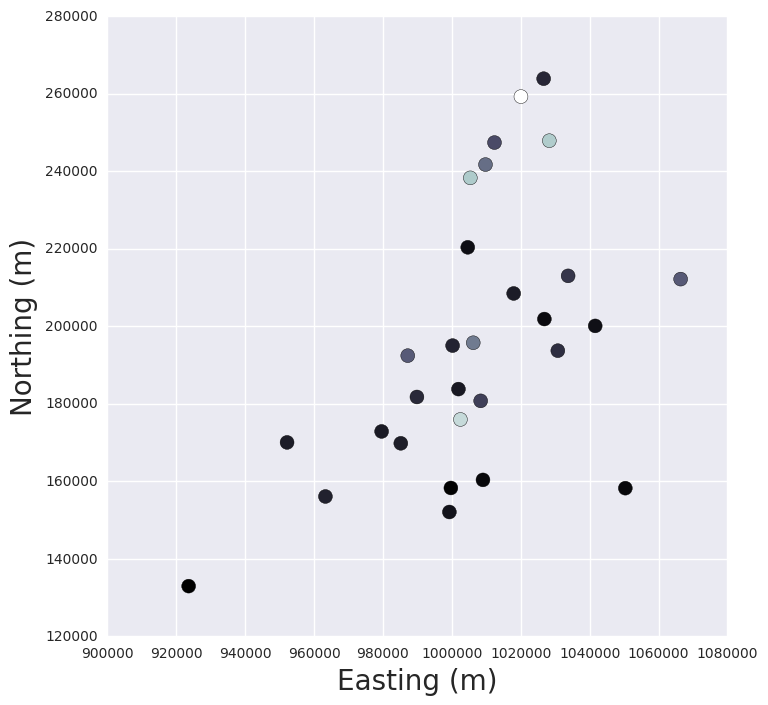

In [83]:
pl.figure(figsize = (8, 8))
pl.scatter(krigdata[:, 1], krigdata[:, 2], c = krigdata[:, 0], s = 100, cmap = 'bone')
pl.xlabel("Easting (m)", fontsize = 20)
pl.ylabel("Northing (m)", fontsize = 20)
pl.show()